<a href="https://colab.research.google.com/github/run-llama/llama_index/blob/main/docs/docs/examples/index_structs/struct_indices/SQLIndexDemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text-to-SQL Guide

This is a basic guide to LlamaIndex's Text-to-SQL capabilities.
1. We first show how to perform text-to-SQL over a toy dataset: this will do "retrieval" (sql query over db) and "synthesis".
2. We then show how to buid a TableIndex over the schema to dynamically retrieve relevant tables during query-time.
3. We finally show you how to define a text-to-SQL retriever on its own.

**NOTE:** Any Text-to-SQL application should be aware that executing
arbitrary SQL queries can be a security risk. It is recommended to
take precautions as needed, such as using restricted roles, read-only
databases, sandboxing, etc.

If you're opening this Notebook on colab, you will probably need to install LlamaIndex 🦙.

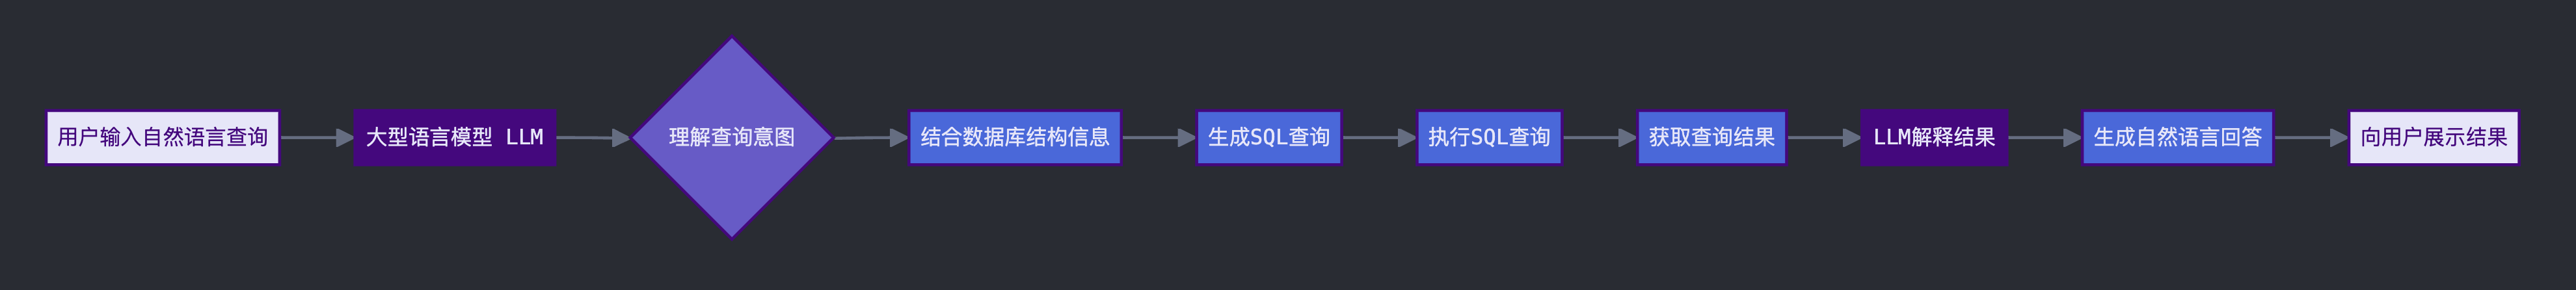

In [1]:
%pip install llama-index-llms-openrouter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.1/375.1 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 13.2 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.0.0
    Uninstalling tenacity-9.0.0:
      Successfully uninstalled tenacity-9.0.0
  Attempting uninstall: nltk
    Found existing installation: nltk 3.8.1
    Uninstalling nltk-3.8.1:
      Successfully uninstalled nl

In [2]:
!pip install llama-index

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.4/187.4 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.8/295.8 kB 16.3 MB/s eta 0:00:00


In [3]:
import os
from llama_index.llms.openrouter import OpenRouter
from llama_index.core.llms import ChatMessage


In [22]:
os.environ["OPENROUTER_API_KEY"] = "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"


In [ ]:
# import logging
# import sys

# logging.basicConfig(stream=sys.stdout, level=logging.INFO)
# logging.getLogger().addHandler(logging.StreamHandler(stream=sys.stdout))

In [5]:
from IPython.display import Markdown, display

### Create Database Schema

使用 sqlalchemy（一种流行的 SQL 数据库工具包）创建一个空的模拟进销存系统的表

In [42]:
from sqlalchemy import (
    create_engine,
    MetaData,
    Table,
    Column,
    String,
    Integer,
    Float,
    select,
    insert,
)


In [43]:
# 创建内存数据库
engine = create_engine("sqlite:///:memory:")
metadata_obj = MetaData()

In [44]:
# 创建产品库存表

table_name = "product_inventory"
product_inventory_table = Table(
    table_name,
    metadata_obj,
    Column("product_id", String(16), primary_key=True),
    Column("product_name", String(50), nullable=False),
    Column("quantity", Integer),
    Column("unit_price", Float),
    Column("category", String(20)),
)
metadata_obj.create_all(engine)



### Define SQL Database

首先定义 SQLDatabase 抽象（SQLAlchemy 的轻型封装）。

In [9]:
from llama_index.core import SQLDatabase


In [32]:
# 初始化LLM
llm = OpenRouter(
    api_key=os.environ.get("OPENROUTER_API_KEY"),
    max_tokens=4096,
    context_window=131072,
    model="qwen/qwen-2.5-72b-instruct",
)


In [46]:
# 创建SQL数据库对象
sql_database = SQLDatabase(engine, include_tables=["product_inventory"])


We add some testing data to our SQL database.

In [47]:
# 创建SQL数据库对象
sql_database = SQLDatabase(engine, include_tables=["product_inventory"])

# 插入50条示例数据
rows = [
    {"product_id": "E001", "product_name": "ThinkPad X1笔记本", "quantity": 50, "unit_price": 8999.99, "category": "电子产品"},
    {"product_id": "E002", "product_name": "戴尔显示器27寸", "quantity": 100, "unit_price": 1499.99, "category": "电子产品"},
    {"product_id": "E003", "product_name": "罗技无线键鼠套装", "quantity": 200, "unit_price": 299.99, "category": "电子产品"},
    {"product_id": "E004", "product_name": "佳能打印机", "quantity": 30, "unit_price": 1999.99, "category": "办公设备"},
    {"product_id": "E005", "product_name": "华为手机Mate50", "quantity": 80, "unit_price": 5999.99, "category": "电子产品"},
    {"product_id": "F001", "product_name": "人体工学办公椅", "quantity": 100, "unit_price": 999.99, "category": "办公家具"},
    {"product_id": "F002", "product_name": "钢制文件柜", "quantity": 40, "unit_price": 799.99, "category": "办公家具"},
    {"product_id": "F003", "product_name": "会议桌", "quantity": 20, "unit_price": 2999.99, "category": "办公家具"},
    {"product_id": "F004", "product_name": "书架", "quantity": 60, "unit_price": 599.99, "category": "办公家具"},
    {"product_id": "F005", "product_name": "办公沙发", "quantity": 15, "unit_price": 3999.99, "category": "办公家具"},
    {"product_id": "S001", "product_name": "订书机", "quantity": 500, "unit_price": 15.99, "category": "办公用品"},
    {"product_id": "S002", "product_name": "记事本", "quantity": 1000, "unit_price": 9.99, "category": "办公用品"},
    {"product_id": "S003", "product_name": "签字笔（盒）", "quantity": 800, "unit_price": 19.99, "category": "办公用品"},
    {"product_id": "S004", "product_name": "文件夹", "quantity": 600, "unit_price": 5.99, "category": "办公用品"},
    {"product_id": "S005", "product_name": "计算器", "quantity": 300, "unit_price": 39.99, "category": "办公用品"},
    {"product_id": "E006", "product_name": "iPad Pro", "quantity": 70, "unit_price": 6499.99, "category": "电子产品"},
    {"product_id": "E007", "product_name": "AirPods Pro", "quantity": 150, "unit_price": 1999.99, "category": "电子产品"},
    {"product_id": "E008", "product_name": "机械键盘", "quantity": 120, "unit_price": 499.99, "category": "电子产品"},
    {"product_id": "E009", "product_name": "华硕ROG游戏本", "quantity": 40, "unit_price": 12999.99, "category": "电子产品"},
    {"product_id": "E010", "product_name": "索尼降噪耳机", "quantity": 90, "unit_price": 2499.99, "category": "电子产品"},
    {"product_id": "F006", "product_name": "组合式办公桌", "quantity": 50, "unit_price": 1599.99, "category": "办公家具"},
    {"product_id": "F007", "product_name": "员工储物柜", "quantity": 80, "unit_price": 699.99, "category": "办公家具"},
    {"product_id": "F008", "product_name": "白板", "quantity": 30, "unit_price": 399.99, "category": "办公家具"},
    {"product_id": "F009", "product_name": "折叠会议桌", "quantity": 25, "unit_price": 1999.99, "category": "办公家具"},
    {"product_id": "F010", "product_name": "接待前台", "quantity": 5, "unit_price": 4999.99, "category": "办公家具"},
    {"product_id": "S006", "product_name": "彩色便利贴", "quantity": 1200, "unit_price": 3.99, "category": "办公用品"},
    {"product_id": "S007", "product_name": "裁纸刀", "quantity": 400, "unit_price": 8.99, "category": "办公用品"},
    {"product_id": "S008", "product_name": "文件盒", "quantity": 350, "unit_price": 12.99, "category": "办公用品"},
    {"product_id": "S009", "product_name": "胶水", "quantity": 700, "unit_price": 4.99, "category": "办公用品"},
    {"product_id": "S010", "product_name": "回形针（盒）", "quantity": 1500, "unit_price": 2.99, "category": "办公用品"},
    {"product_id": "E011", "product_name": "投影仪", "quantity": 25, "unit_price": 3999.99, "category": "办公设备"},
    {"product_id": "E012", "product_name": "碎纸机", "quantity": 35, "unit_price": 599.99, "category": "办公设备"},
    {"product_id": "E013", "product_name": "扫描仪", "quantity": 20, "unit_price": 1299.99, "category": "办公设备"},
    {"product_id": "E014", "product_name": "复印机", "quantity": 15, "unit_price": 8999.99, "category": "办公设备"},
    {"product_id": "E015", "product_name": "路由器", "quantity": 40, "unit_price": 399.99, "category": "网络设备"},
    {"product_id": "F011", "product_name": "办公屏风", "quantity": 60, "unit_price": 899.99, "category": "办公家具"},
    {"product_id": "F012", "product_name": "活动柜", "quantity": 70, "unit_price": 499.99, "category": "办公家具"},
    {"product_id": "F013", "product_name": "茶水柜", "quantity": 10, "unit_price": 1299.99, "category": "办公家具"},
    {"product_id": "F014", "product_name": "休闲沙发", "quantity": 8, "unit_price": 2999.99, "category": "办公家具"},
    {"product_id": "F015", "product_name": "立式衣架", "quantity": 45, "unit_price": 129.99, "category": "办公家具"},
    {"product_id": "S011", "product_name": "起钉器", "quantity": 450, "unit_price": 7.99, "category": "办公用品"},
    {"product_id": "S012", "product_name": "文件袋", "quantity": 800, "unit_price": 1.99, "category": "办公用品"},
    {"product_id": "S013", "product_name": "标签纸", "quantity": 600, "unit_price": 11.99, "category": "办公用品"},
    {"product_id": "S014", "product_name": "快劳夹", "quantity": 550, "unit_price": 2.49, "category": "办公用品"},
    {"product_id": "S015", "product_name": "印泥", "quantity": 200, "unit_price": 9.99, "category": "办公用品"},
    {"product_id": "E016", "product_name": "视频会议系统", "quantity": 5, "unit_price": 19999.99, "category": "办公设备"},
    {"product_id": "E017", "product_name": "考勤机", "quantity": 10, "unit_price": 999.99, "category": "办公设备"},
    {"product_id": "E018", "product_name": "条码扫描枪", "quantity": 30, "unit_price": 599.99, "category": "办公设备"},
    {"product_id": "E019", "product_name": "UPS不间断电源", "quantity": 20, "unit_price": 1999.99, "category": "电子产品"},
    {"product_id": "E020", "product_name": "电话会议设备", "quantity": 8, "unit_price": 2999.99, "category": "办公设备"},
]

for row in rows:
    stmt = insert(product_inventory_table).values(**row)
    with engine.begin() as connection:
        connection.execute(stmt)


In [49]:
# 查看当前表内容
stmt = select(
    product_inventory_table.c.product_id,
    product_inventory_table.c.product_name,
    product_inventory_table.c.quantity,
    product_inventory_table.c.unit_price,
    product_inventory_table.c.category,
).select_from(product_inventory_table)



### Query Index

In [50]:
#演示如何执行原始 SQL 查询，该查询可直接在表上执行
from sqlalchemy import text

with engine.connect() as connection:
    results = connection.execute(stmt).fetchall()
    for row in results:
        print(row)


('E001', 'ThinkPad X1笔记本', 50, 8999.99, '电子产品')
('E002', '戴尔显示器27寸', 100, 1499.99, '电子产品')
('E003', '罗技无线键鼠套装', 200, 299.99, '电子产品')
('E004', '佳能打印机', 30, 1999.99, '办公设备')
('E005', '华为手机Mate50', 80, 5999.99, '电子产品')
('F001', '人体工学办公椅', 100, 999.99, '办公家具')
('F002', '钢制文件柜', 40, 799.99, '办公家具')
('F003', '会议桌', 20, 2999.99, '办公家具')
('F004', '书架', 60, 599.99, '办公家具')
('F005', '办公沙发', 15, 3999.99, '办公家具')
('S001', '订书机', 500, 15.99, '办公用品')
('S002', '记事本', 1000, 9.99, '办公用品')
('S003', '签字笔（盒）', 800, 19.99, '办公用品')
('S004', '文件夹', 600, 5.99, '办公用品')
('S005', '计算器', 300, 39.99, '办公用品')
('E006', 'iPad Pro', 70, 6499.99, '电子产品')
('E007', 'AirPods Pro', 150, 1999.99, '电子产品')
('E008', '机械键盘', 120, 499.99, '电子产品')
('E009', '华硕ROG游戏本', 40, 12999.99, '电子产品')
('E010', '索尼降噪耳机', 90, 2499.99, '电子产品')
('F006', '组合式办公桌', 50, 1599.99, '办公家具')
('F007', '员工储物柜', 80, 699.99, '办公家具')
('F008', '白板', 30, 399.99, '办公家具')
('F009', '折叠会议桌', 25, 1999.99, '办公家具')
('F010', '接待前台', 5, 4999.99, '办公家具')
('S006', '彩色便利贴

## Part 1: Text-to-SQL Query Engine
Once we have constructed our SQL database, we can use the NLSQLTableQueryEngine to
construct natural language queries that are synthesized into SQL queries.

Note that we need to specify the tables we want to use with this query engine.
If we don't the query engine will pull all the schema context, which could
overflow the context window of the LLM.

In [53]:
from llama_index.core.query_engine import NLSQLTableQueryEngine

# 创建查询引擎
query_engine = NLSQLTableQueryEngine(
    sql_database=sql_database, tables=["product_inventory"], llm=llm
)

# 示例查询
query_str = "哪个类别的产品种类最多？"
response = query_engine.query(query_str)

display(Markdown(f"<b>{response}</b>"))

<b>根据查询结果，产品种类最多的类别是办公用品，共有15种不同的产品。</b>

In [54]:
# 示例查询2：高价值产品
query_str = "列出单价超过5000元的所有产品名称和价格，按价格从高到低排序。"
response = query_engine.query(query_str)
display(Markdown(f"<b>查询2：{query_str}</b>\n{response}"))


<b>查询2：列出单价超过5000元的所有产品名称和价格，按价格从高到低排序。</b>
以下是单价超过5000元的所有产品名称和价格，按价格从高到低排序：

1. 视频会议系统 - 19999.99元
2. 华硕ROG游戏本 - 12999.99元
3. ThinkPad X1笔记本 - 8999.99元
4. 复印机 - 8999.99元
5. iPad Pro - 6499.99元
6. 华为手机Mate50 - 5999.99元

In [55]:
# 示例查询3：库存管理
query_str = "哪些产品的库存数量低于30件？请列出产品名称和具体数量。"
response = query_engine.query(query_str)
display(Markdown(f"<b>查询3：{query_str}</b>\n{response}"))



<b>查询3：哪些产品的库存数量低于30件？请列出产品名称和具体数量。</b>
以下产品的库存数量低于30件：

- 会议桌：20件
- 办公沙发：15件
- 折叠会议桌：25件
- 接待前台：5件
- 投影仪：25件
- 扫描仪：20件
- 复印机：15件
- 茶水柜：10件
- 休闲沙发：8件
- 视频会议系统：5件
- 考勤机：10件
- UPS不间断电源：20件
- 电话会议设备：8件

In [ ]:
# 示例查询4：类别分析
query_str = "计算每个类别的平均单价，并按平均单价从高到低排序。"
response = query_engine.query(query_str)
display(Markdown(f"<b>查询4：{query_str}</b>\n{response}"))


In [ ]:
# 示例查询5：库存价值
query_str = "计算总库存价值最高的前5种产品，显示产品名称、数量、单价和总价值。"
response = query_engine.query(query_str)
display(Markdown(f"<b>查询5：{query_str}</b>\n{response}"))



In [ ]:
# 示例查询6：产品多样性
query_str = "在'办公用品'类别中，单价低于10元的产品有哪些？请列出它们的名称和价格。"
response = query_engine.query(query_str)
display(Markdown(f"<b>查询6：{query_str}</b>\n{response}"))



In [ ]:
# 示例查询7：库存周转
query_str = "假设月销量是当前库存的10%，哪些产品的库存可以支撑超过12个月？列出产品名称和预计可支撑的月数。"
response = query_engine.query(query_str)
display(Markdown(f"<b>查询7：{query_str}</b>\n{response}"))


In [56]:
# 示例查询8：价格区间分析
query_str = "将产品按价格划分为三类：低价（1000元以下），中价（1000-5000元），高价（5000元以上）。计算每类产品的数量和平均单价。"
response = query_engine.query(query_str)
display(Markdown(f"<b>查询8：{query_str}</b>\n{response}"))


<b>查询8：将产品按价格划分为三类：低价（1000元以下），中价（1000-5000元），高价（5000元以上）。计算每类产品的数量和平均单价。</b>
根据查询结果，产品按价格分类如下：

- 低价（1000元以下）：共有29个产品，平均单价为296.21元。
- 中价（1000-5000元）：共有15个产品，平均单价为2546.66元。
- 高价（5000元以上）：共有6个产品，平均单价为10583.32元。